# Predicate Enumeration

To construct the initial state of a problem, and to identify action failures, we have no other option but to exhaustively enumerate each possible predicate and verify them with the VLM.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.path.dirname(os.path.abspath('.')))
print("ROOT", ROOT)

ROOT /scratch/cs/world-models/merlerm1/open-world-symbolic-planner


In [2]:
sys.path.append(ROOT)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader

from PIL import Image
import matplotlib.pyplot as plt

from viplan.planning.blocksworld_simulator import BlocksworldSimulator
from viplan.code_helpers import get_logger

In [5]:
DOMAIN_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'domain.pddl')
# PROBLEM_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'test_problem_3.pddl')
PROBLEM_FILE = os.path.join(ROOT, 'data', 'planning', 'blocksworld', 'problems', 'simple', 'simple_problem_8.pddl')

reader = PDDLReader()
problem = reader.parse_problem(DOMAIN_FILE, PROBLEM_FILE)

In [6]:
def plot_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

[INFO] [11:07:54] GPU rendering: True
[INFO] [11:07:56] Rendered state in 1.91 seconds


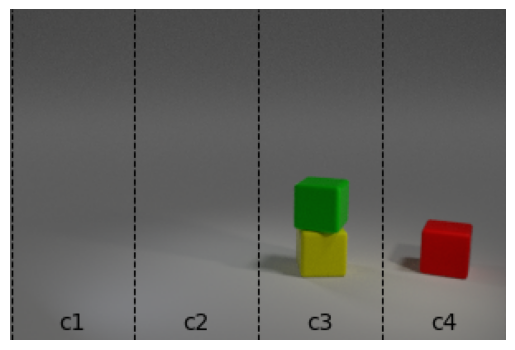

In [7]:
logger = get_logger(log_level='info')
env = BlocksworldSimulator(problem, root_path=ROOT, logger=logger, seed=1, use_gpu_rendering=True)
plot_image(env.render())

In [8]:
env.state

{'on': defaultdict(<function viplan.planning.blocksworld_simulator.BlocksworldSimulator._init_state_from_problem.<locals>.<lambda>(*arg_names)>,
             {'g,y': True,
              'y,y': False,
              'r,y': False,
              'y,r': False,
              'r,r': False,
              'g,r': False,
              'y,g': False,
              'r,g': False,
              'g,g': False}),
 'incolumn': defaultdict(<function viplan.planning.blocksworld_simulator.BlocksworldSimulator._init_state_from_problem.<locals>.<lambda>(*arg_names)>,
             {'y,c3': True,
              'r,c4': True,
              'g,c3': True,
              'y,c1': False,
              'r,c1': False,
              'g,c1': False,
              'y,c2': False,
              'r,c2': False,
              'g,c2': False,
              'r,c3': False,
              'y,c4': False,
              'g,c4': False}),
 'clear': defaultdict(<function viplan.planning.blocksworld_simulator.BlocksworldSimulator._init_state_f

In [9]:
for predicate in env.state:
    print(f"Predicate {predicate} has {len(list(env.state[predicate].keys()))} combinations")
    
total_combinations = sum(len(list(env.state[predicate].keys())) for predicate in env.state)
print(f"Total combinations: {total_combinations}")

Predicate on has 9 combinations
Predicate incolumn has 12 combinations
Predicate clear has 3 combinations
Predicate rightof has 16 combinations
Predicate leftof has 16 combinations
Total combinations: 56


In [10]:
predicate_questions = {
    'on': 'Is the {b1} on top of the {b2}?',
    'clear': 'Is the {b} the topmost of its column?',
    'incolumn': 'Is the {b} in the {c}?',
    'rightof': 'Is the {c1} to the right of the {c2}?',
    'leftof': 'Is the {c1} to the left of the {c2}?',
}

block_templates = {
    'r': 'red block',
    'g': 'green block',
    'b': 'blue block',
    'y': 'yellow block',
    'o': 'orange block',
    'p': 'purple block',
}

column_templates = {
    'c1': 'column labeled "c1"',
    'c2': 'column labeled "c2"',
    'c3': 'column labeled "c3"',
    'c4': 'column labeled "c4"',
    'c5': 'column labeled "c5"',
} 

In [11]:
def get_questions(predicates, block_templates, column_templates):
    questions = {}
    for pred in predicates:
        predicate = str(pred)
        for args_str in predicates[pred]:
            args = tuple(args_str.split(','))
            value = predicates[pred][args_str]
            
            if predicate == 'on':
                b1 = block_templates[args[0]]
                b2 = block_templates[args[1]]
                questions[predicate + " " + args_str] = (predicate_questions[predicate].format(b1=b1, b2=b2), value)
            elif predicate == 'clear':
                b = block_templates[args[0]]
                questions[predicate + " " + args_str] = (predicate_questions[predicate].format(b=b), value)
            elif predicate == 'incolumn':
                b = block_templates[args[0]]
                c = column_templates[args[1]]
                questions[predicate + " " + args_str] = (predicate_questions[predicate].format(b=b, c=c), value)
            elif predicate == 'rightof':
                c1 = column_templates[args[0]]
                c2 = column_templates[args[1]]
                questions[predicate + " " + args_str] = (predicate_questions[predicate].format(c1=c1, c2=c2), value)
            elif predicate == 'leftof':
                c1 = column_templates[args[0]]
                c2 = column_templates[args[1]]
                questions[predicate + " " + args_str] = (predicate_questions[predicate].format(c1=c1, c2=c2), value)
            else:
                raise ValueError(f"Unknown predicate {predicate}")
    
    return questions


In [12]:
get_questions(env.state, block_templates, column_templates)

{'on g,y': ('Is the green block on top of the yellow block?', True),
 'on y,y': ('Is the yellow block on top of the yellow block?', False),
 'on r,y': ('Is the red block on top of the yellow block?', False),
 'on y,r': ('Is the yellow block on top of the red block?', False),
 'on r,r': ('Is the red block on top of the red block?', False),
 'on g,r': ('Is the green block on top of the red block?', False),
 'on y,g': ('Is the yellow block on top of the green block?', False),
 'on r,g': ('Is the red block on top of the green block?', False),
 'on g,g': ('Is the green block on top of the green block?', False),
 'incolumn y,c3': ('Is the yellow block in the column labeled "c3"?', True),
 'incolumn r,c4': ('Is the red block in the column labeled "c4"?', True),
 'incolumn g,c3': ('Is the green block in the column labeled "c3"?', True),
 'incolumn y,c1': ('Is the yellow block in the column labeled "c1"?', False),
 'incolumn r,c1': ('Is the red block in the column labeled "c1"?', False),
 'inco

In [13]:
# Print distribution of true/false values for each predicate
def print_distribution(questions):
    counts_per_predicate = {}
    for grounded_predicate, (question, value) in questions.items():
        predicate = grounded_predicate.split(" ")[0]
        if predicate not in counts_per_predicate:
            counts_per_predicate[predicate] = {'true': 0, 'false': 0}
        counts_per_predicate[predicate]['true' if value else 'false'] += 1

    for predicate, counts in counts_per_predicate.items():
        print(f"Predicate {predicate}: {counts['true']} true ({counts['true'] / (counts['true'] + counts['false']) * 100:.2f}%), {counts['false']} false ({counts['false'] / (counts['true'] + counts['false']) * 100:.2f}%)")

print_distribution(get_questions(env.state, block_templates, column_templates))

Predicate on: 1 true (11.11%), 8 false (88.89%)
Predicate incolumn: 3 true (25.00%), 9 false (75.00%)
Predicate clear: 2 true (66.67%), 1 false (33.33%)
Predicate rightof: 3 true (18.75%), 13 false (81.25%)
Predicate leftof: 3 true (18.75%), 13 false (81.25%)


## Asking the VLM

In [14]:
import torch
import transformers

from viplan.models import HuggingFaceVLM
from viplan.code_helpers import get_logger, parse_output

torch.manual_seed(1)
transformers.set_seed(1)

In [15]:
logger = get_logger(log_level='info')

model_name = "Qwen/Qwen2.5-VL-7B-Instruct"
# model_name = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
hf_cache_dir = "/scratch/cs/world-models/hf_models"

logger.info(f"Using GPU: {torch.cuda.get_device_name()}." if torch.cuda.is_available() else "Using CPU.")
if torch.cuda.is_available() and 'A100' in torch.cuda.get_device_name() or 'H100' in torch.cuda.get_device_name() or 'H200' in torch.cuda.get_device_name():
    use_flash_attn = True
else:
    use_flash_attn = False
logger.info(f"Use flash attention: {use_flash_attn}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

model = HuggingFaceVLM(model_name, cache_dir=hf_cache_dir, logger=logger, temperature=0, device=device, dtype=dtype, use_flash_attn=use_flash_attn)

[INFO] [11:08:06] Using GPU: NVIDIA H100 80GB HBM3.
[INFO] [11:08:06] Use flash attention: True
[INFO] [11:08:06] Loading model Qwen/Qwen2.5-VL-7B-Instruct
[INFO] [11:08:06] Trust remote code: False


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] [11:08:15] Model Qwen/Qwen2.5-VL-7B-Instruct loaded on device cuda with torch.bfloat16 precision.


In [16]:
def get_responses(env, model, questions, base_prompt, batch_size=64):
    responses = []
    base_prompt = open(base_prompt, 'r').read()
    q_list = [ base_prompt + "\n" + question[0] for question in questions.values() ]
    
    for i in range(0, len(questions), batch_size):
        print(f"Processing questions {i} to {min(i + batch_size, len(q_list))} of {len(q_list)}")
        batch_prompts = q_list[i:i + min(batch_size, len(q_list) - i)]
        print(len(batch_prompts))
        img = env.render()
        batch_images = [img] * len(batch_prompts)
        batch_responses = model.generate(prompts=batch_prompts, images=batch_images, return_probs=True)
        print(f"Got {len(batch_responses)} responses")
        responses.extend(batch_responses)
        
    assert len(responses) == len(q_list), "Some answers were not generated."
    return responses
    

In [17]:
base_prompt = os.path.join(ROOT, 'data', 'prompts', 'benchmark', 'OpenImages', 'prompt.md')
questions = get_questions(env.state, block_templates, column_templates)
responses = get_responses(env, model, questions, base_prompt, batch_size=64)

Processing questions 0 to 56 of 56
56
[INFO] [11:08:17] Rendered state in 1.64 seconds
Got 56 responses


In [18]:
correct = 0
yes_correct = 0
no_correct = 0
total_yes = 0
total_no = 0

for i, (question, response) in enumerate(zip(questions, responses)):
    question_str = questions[question][0]
    answer = 'Yes' if questions[question][1] else 'No'
    response, found_cot = parse_output(response[0])
    total_yes += 1 if questions[question][1] else 0
    total_no += 1 if not questions[question][1] else 0
    if answer.lower() == response.lower():
        correct += 1
        if questions[question][1]:
            yes_correct += 1
        else:
            no_correct += 1
        # print(f"Q{i}: {question_str} => {response} (correct)")
    # else:
        # print(f"Q{i}: {question_str} => {response} (incorrect, expected {answer})")
print(f"Accuracy: {correct / len(responses) * 100:.2f}%")
print(f"Yes accuracy: {yes_correct / total_yes * 100:.2f}%")
print(f"No accuracy: {no_correct / total_no * 100:.2f}%")

Accuracy: 85.71%
Yes accuracy: 91.67%
No accuracy: 84.09%


In [19]:
# Print the accuracy for each predicate (also the yes/no accuracy)

predicate_accuracy = {}

for i, (question, response) in enumerate(zip(questions, responses)):
    question_str = questions[question][0]
    answer = 'Yes' if questions[question][1] else 'No'
    response, found_cot = parse_output(response[0])
    predicate = question.split(" ")[0]
    
    if predicate not in predicate_accuracy:
        predicate_accuracy[predicate] = {'correct': 0, 'yes_correct': 0, 'no_correct': 0, 'total': 0, 'yes_total': 0, 'no_total': 0}
    
    predicate_accuracy[predicate]['total'] += 1
    predicate_accuracy[predicate]['yes_total'] += 1 if questions[question][1] else 0
    predicate_accuracy[predicate]['no_total'] += 1 if not questions[question][1] else 0
    if answer.lower() == response.lower():
        predicate_accuracy[predicate]['correct'] += 1
        if questions[question][1]:
            predicate_accuracy[predicate]['yes_correct'] += 1
        else:
            predicate_accuracy[predicate]['no_correct'] += 1

for predicate, counts in predicate_accuracy.items():
    print(f"Predicate {predicate}: {counts['correct']} correct ({counts['correct'] / counts['total'] * 100:.2f}%), {counts['yes_correct']} yes correct ({counts['yes_correct'] / counts['yes_total'] * 100:.2f}%), {counts['no_correct']} no correct ({counts['no_correct'] / counts['no_total'] * 100:.2f}%)")

Predicate on: 9 correct (100.00%), 1 yes correct (100.00%), 8 no correct (100.00%)
Predicate incolumn: 12 correct (100.00%), 3 yes correct (100.00%), 9 no correct (100.00%)
Predicate clear: 1 correct (33.33%), 1 yes correct (50.00%), 0 no correct (0.00%)
Predicate rightof: 13 correct (81.25%), 3 yes correct (100.00%), 10 no correct (76.92%)
Predicate leftof: 13 correct (81.25%), 3 yes correct (100.00%), 10 no correct (76.92%)


In [20]:
def update_vlm_state(vlm_state, results):
    changed = []
    for key, result in results.items():
        if key == 'all_correct':
            continue
        pred, args = key.split(" ")
        assert result[0] == 'yes' or result[0] == 'no', f"VLM gave unexpected answer {result[0]}"
        new_value = True if result[0] == 'yes' else False
        if vlm_state[pred][args] != new_value:
            vlm_state[pred][args] = new_value
            changed_str = f"{pred} {args} to {new_value}" # Str for better logging, later we can use the key
            changed.append(changed_str)

    return vlm_state, changed

In [21]:
import copy

vlm_state = copy.deepcopy(env.state)

results = {}
for i, (question, response) in enumerate(zip(questions, responses)):
    question_str = questions[question][0]
    answer = 'Yes' if questions[question][1] else 'No'
    response, found_cot = parse_output(response[0])
    results[question] = (response.lower(), answer.lower())

updated_vlm_state, changed = update_vlm_state(vlm_state, results)

# Print differences between the original and updated VLM state
for predicate in env.state:
    for args_str in env.state[predicate]:
        if env.state[predicate][args_str] != updated_vlm_state[predicate][args_str]:
            print(f"Predicate {predicate} with args {args_str} changed from {env.state[predicate][args_str]} to {updated_vlm_state[predicate][args_str]}")

Predicate clear with args r changed from True to False
Predicate clear with args y changed from False to True
Predicate rightof with args c3,c1 changed from False to True
Predicate rightof with args c4,c1 changed from False to True
Predicate rightof with args c4,c2 changed from False to True
Predicate leftof with args c1,c3 changed from False to True
Predicate leftof with args c1,c4 changed from False to True
Predicate leftof with args c2,c4 changed from False to True


In [22]:
from unified_planning.environment import get_environment

def update_problem(state, problem):
    
    def get_new_problem_fluent(new_problem, fluent):
        for new_fluent in new_problem.initial_values:
            if str(new_fluent) == str(fluent):
                return new_fluent
        return None
       
    new_problem = copy.deepcopy(problem)

    up_env = get_environment()
    expr_manager = up_env.expression_manager
    
    for fluent in problem.initial_values:
        
        name = fluent.fluent().name
        args = fluent.args
        args_str = ",".join([str(arg) for arg in args])
        value = problem.initial_values[fluent].is_true()
        state_value = state[name][args_str]
        if value != state_value:
            assert problem.initial_values[fluent].is_bool_constant()
            new_fluent = get_new_problem_fluent(new_problem, fluent)
            if new_fluent is None:
                raise ValueError(f"Fluent {fluent} not found in new_problem")

            new_problem.initial_values[new_fluent] = expr_manager.true_expression if state_value else expr_manager.false_expression
            print(f"Updating {new_fluent} from {problem.initial_values[fluent]} to {new_problem.initial_values[new_fluent]}")
            
    return new_problem

In [36]:
problem = env.problem
problem

problem name = simple_problem_8

types = [block, column]

fluents = [
  bool on[b1=block, b2=block]
  bool incolumn[b=block, c=column]
  bool clear[b=block]
  bool rightof[c1=column, c2=column]
  bool leftof[c1=column, c2=column]
]

actions = [
  action moveblock(block b1, column c1) {
    preconditions = [
      (clear(b1) and (not incolumn(b1, c1)))
    ]
    effects = [
      incolumn(b1, c1) := true
      clear(b1) := true
      forall column c2 if incolumn(b1, c2) then incolumn(b1, c2) := false
      forall block b2 if on(b1, b2) then on(b1, b2) := false
      forall block b2 if on(b1, b2) then clear(b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then on(b1, b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then clear(b2) := false
    ]
  }
]

objects = [
  block: [y, r, g]
  column: [c1, c2, c3, c4]
]

initial fluents default = [
  bool on[b1=block, b2=block] := false
  bool incolumn[b=block, c=c

In [32]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_764386/4173542664.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

Fast Downward returned: SequentialPlan:
    moveblock(r, c1)
    moveblock(g, c4)
    moveblock(y, c2)
    moveblock(r, c3)


In [37]:
new_problem = update_problem(updated_vlm_state, problem)
new_problem

Updating clear(r) from true to false
Updating clear(y) from false to true
Updating rightof(c3, c1) from false to true
Updating rightof(c4, c1) from false to true
Updating rightof(c4, c2) from false to true
Updating leftof(c1, c3) from false to true
Updating leftof(c1, c4) from false to true
Updating leftof(c2, c4) from false to true


problem name = simple_problem_8

types = [block, column]

fluents = [
  bool on[b1=block, b2=block]
  bool incolumn[b=block, c=column]
  bool clear[b=block]
  bool rightof[c1=column, c2=column]
  bool leftof[c1=column, c2=column]
]

actions = [
  action moveblock(block b1, column c1) {
    preconditions = [
      (clear(b1) and (not incolumn(b1, c1)))
    ]
    effects = [
      incolumn(b1, c1) := true
      clear(b1) := true
      forall column c2 if incolumn(b1, c2) then incolumn(b1, c2) := false
      forall block b2 if on(b1, b2) then on(b1, b2) := false
      forall block b2 if on(b1, b2) then clear(b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then on(b1, b2) := true
      forall block b2 if (incolumn(b2, c1) and clear(b2) and (not (b2 == b1))) then clear(b2) := false
    ]
  }
]

objects = [
  block: [y, r, g]
  column: [c1, c2, c3, c4]
]

initial fluents default = [
  bool on[b1=block, b2=block] := false
  bool incolumn[b=block, c=c

In [39]:
with OneshotPlanner(problem_kind=new_problem.kind) as planner:
    result = planner.solve(new_problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Fast Downward returned: %s" % result.plan)
    else:
        print("No plan found.")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `/tmp/ipykernel_764386/3634134506.py`, you are using the following planning engine:
  * Engine name: Fast Downward
  * Developers:  Uni Basel team and contributors (cf. https://github.com/aibasel/downward/blob/main/README.md)
  * Description: Fast Downward is a domain-independent classical planning system.

No plan found.
